In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.style as style
from sklearn.preprocessing import MinMaxScaler

In [2]:
links = pd.read_csv('links_small.csv')
ratings = pd.read_csv('ratings_small.csv')
movies = pd.read_csv('movies.csv')

In [3]:
merged_df = pd.merge(movies, links, left_on='id', right_on='tmdbId')[['id', 'movieId']]
merged_df

,id,movieId
0,19995,72998
1,285,53125
2,206647,136020
3,49026,91529
4,49529,93363
...,...,...
3399,692,2361
3400,13898,4252
3401,36095,4645
3402,14337,8914


In [4]:
merged_df = pd.merge(merged_df, ratings, on='movieId', how='inner').drop(['timestamp'], axis=1)
merged_df

,id,movieId,userId,rating
0,19995,72998,15,4.0
1,19995,72998,26,3.5
2,19995,72998,31,4.0
3,19995,72998,48,4.5
4,19995,72998,72,2.0
...,...,...,...,...
66942,9367,3267,460,3.5
66943,9367,3267,580,4.0
66944,9367,3267,596,3.5
66945,9367,3267,624,3.5


In [5]:
filter_df = merged_df.groupby('id').count().sort_values('rating', ascending=False)

In [6]:
filter_df = filter_df.loc[filter_df.rating >= filter_df.rating.quantile(0.85)]

In [7]:
filter_df

,movieId,userId,rating
id,,,
13,341,341,341
680,324,324,324
278,311,311,311
274,304,304,304
11,291,291,291
...,...,...,...
1710,38,38,38
675,38,38,38
8584,38,38,38


In [8]:
filter_df = filter_df.drop(['movieId', 'userId', 'rating'], axis=1)

In [9]:
df = pd.merge(filter_df, merged_df, left_index=True, right_on='id', how='inner')
df

,id,movieId,userId,rating
19419,13,356,2,3.0
19420,13,356,3,5.0
19421,13,356,4,5.0
19422,13,356,5,4.0
19423,13,356,7,3.0
...,...,...,...,...
60897,10774,3504,547,5.0
60898,10774,3504,564,4.0
60899,10774,3504,575,2.0
60900,10774,3504,585,4.0


In [10]:
result = df.pivot_table(index='userId', columns='id', values='rating')

In [11]:
result

id,11,12,13,14,18,22,24,28,33,38,...,36819,36955,37165,37233,37799,45269,49026,68718,70160,157336
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
def fillna_rating(x):
    return x.fillna(x.mean())
result1 = result.apply(fillna_rating, axis=0)    

In [13]:
result1

id,11,12,13,14,18,22,24,28,33,38,...,36819,36955,37165,37233,37799,45269,49026,68718,70160,157336
userId,,,,,,,,,,,,,,,,,,,,,
1,4.221649,3.803279,4.054252,4.236364,3.677966,3.85461,3.81982,4.138393,3.885965,4.122642,...,1.000000,3.515152,3.886861,3.472727,3.976744,3.925,3.6875,3.977273,3.381579,4.151163
2,4.221649,3.803279,3.000000,4.236364,3.677966,3.85461,3.81982,4.138393,3.885965,4.122642,...,3.569767,3.515152,3.886861,4.000000,3.976744,3.925,3.6875,3.977273,3.381579,4.151163
3,4.221649,3.000000,5.000000,4.000000,3.677966,3.85461,3.81982,4.138393,3.885965,3.000000,...,3.569767,3.515152,3.886861,3.472727,3.976744,3.925,3.6875,3.977273,3.381579,4.151163
4,5.000000,3.803279,5.000000,4.236364,3.677966,3.85461,3.81982,5.000000,3.885965,4.122642,...,5.000000,3.000000,3.886861,3.472727,3.976744,3.925,3.6875,3.977273,3.381579,4.151163
5,4.221649,4.000000,4.000000,4.236364,3.677966,3.85461,3.81982,4.138393,3.885965,4.122642,...,3.569767,3.515152,4.000000,3.472727,3.976744,3.925,3.6875,3.977273,3.381579,4.151163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,4.221649,3.803279,4.000000,4.236364,3.677966,3.85461,3.81982,4.138393,3.885965,4.122642,...,3.569767,3.000000,3.886861,3.000000,3.976744,3.925,3.6875,3.977273,3.381579,4.151163
668,4.221649,3.803279,4.054252,4.236364,3.677966,3.85461,3.81982,4.138393,3.885965,4.122642,...,3.569767,3.515152,3.886861,3.472727,3.976744,3.925,3.6875,3.977273,3.381579,4.151163
669,5.000000,3.803279,4.054252,4.236364,3.677966,3.85461,3.81982,4.138393,3.885965,4.122642,...,3.569767,3.515152,3.886861,3.472727,3.976744,3.925,3.6875,3.977273,3.381579,4.151163


In [14]:
from sklearn.decomposition import PCA
re_afterpca = PCA(n_components=0.8).fit_transform(result1)

In [15]:
df = pd.DataFrame(re_afterpca)

In [16]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

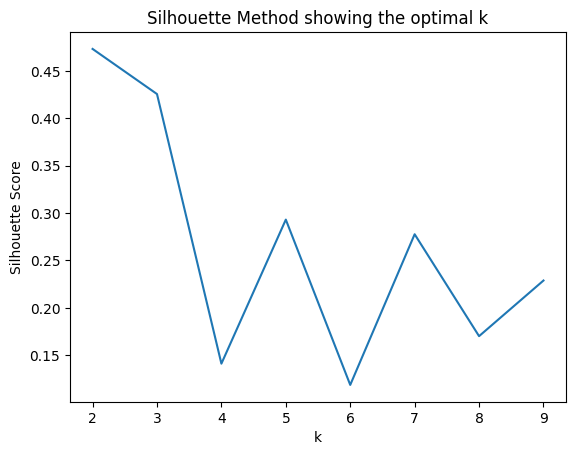

In [17]:
silhouette_scores = [] 
range_values = range(2, 10)

for i in range_values:
    kmeans = KMeans(n_clusters=i).fit(df)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(df, labels, metric = 'euclidean'))

plt.plot(range_values, silhouette_scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method showing the optimal k')
plt.show()

c:\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


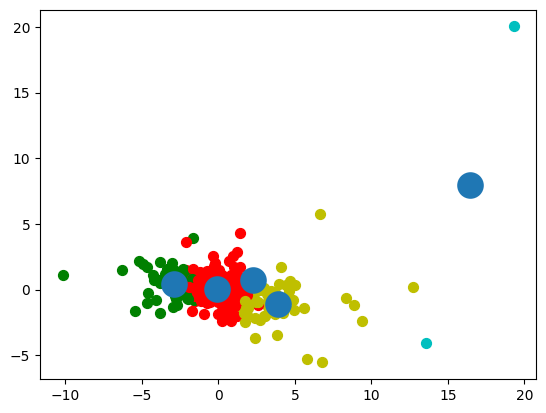

In [18]:
kmeans = KMeans(n_clusters=5).fit(df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i in range(len(df)):
    plt.scatter(df.iloc[i, 0], df.iloc[i, 1], color=colors[labels[i]], s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=200, linewidths=5, zorder=10)
plt.show()

In [19]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df)

In [20]:
kmeans.labels_

array([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3,
       3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3,
       3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2,
       3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3,

In [21]:
df['cluster'] = pd.Series(kmeans.labels_)

In [22]:
df

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,cluster
0,0.275552,-0.044823,-0.300742,0.010809,-0.163145,0.208688,-0.080941,-0.389584,-0.197646,-0.099756,...,-0.016414,-0.086622,0.359939,0.057627,-0.012759,-0.701431,0.273706,0.114924,0.177043,3
1,0.132589,-0.129551,-0.040333,0.175622,-0.102898,0.157028,0.100049,0.289029,0.405056,-0.071468,...,-0.195941,-0.434294,0.771583,-0.129156,-0.428287,-0.197162,0.072631,0.165549,0.224429,3
2,0.427108,-0.714111,0.913604,0.361333,-0.116612,0.103848,-0.125498,-0.417725,-0.244978,0.138948,...,0.115180,-0.217322,0.102182,0.091023,-0.056233,-0.390041,-0.113891,-0.104383,-0.174250,3
3,-3.806622,2.133804,2.517724,0.230686,0.923075,0.474126,-1.123186,1.536945,-0.048058,1.523606,...,0.554428,0.066369,-0.469557,0.332033,-0.223221,0.601332,0.573953,0.049495,0.064504,2
4,-1.552042,-0.832338,-0.075266,0.636240,-0.372845,1.483735,0.678190,-0.118136,-0.403349,-0.276901,...,0.663187,0.097920,0.399018,0.632490,0.846585,0.381423,0.084559,-0.239862,-0.030808,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0.323200,-0.061683,-0.159476,-0.440032,-0.050471,0.274355,0.138854,0.220057,-0.083854,-0.085507,...,-0.116832,-0.032396,-0.043155,-0.129740,0.012521,-0.046812,-0.104356,0.194292,-0.283201,3
665,-0.076206,0.191564,0.174124,-0.167869,0.132582,-0.343401,0.033752,-0.033282,0.063898,-0.171257,...,0.028211,0.182380,0.021216,0.020592,-0.166599,-0.172719,0.001937,-0.004959,0.303426,3
666,-0.113939,-0.029160,0.094196,-0.222747,0.173240,0.079572,-0.104618,-0.135113,-0.042107,-0.101234,...,0.159574,0.207237,-0.265598,-0.078647,0.008264,-0.007992,-0.051592,0.056680,-0.289867,3
667,0.050961,-0.216133,-0.159815,-0.346365,1.141716,-0.096951,0.363454,0.111692,0.205256,0.243860,...,-0.215872,0.508329,-0.185442,0.443356,0.164581,-0.041230,0.167945,0.607852,-0.431418,3


In [23]:
X = df.iloc[:, 0:136].values
y = df.iloc[:, 136].values

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [25]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [26]:
y_pred = classifier.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[  0   0   1   1]
 [  0   0   0   1]
 [  0   0  25   4]
 [  0   0   2 100]]


0.9328358208955224